In [1]:
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from matplotlib.pyplot import figure
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [3]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [4]:
model = load_model('/data/Data/yntn/model_LSTM_focal_loss_3.hdf5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})

In [5]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [6]:
tok = pickle.load (open("/data/Data/yntn/emotion-detection-from-text/tokenize.pkl",'rb'))

In [7]:
df = pd.read_csv ('/data/Data/yntn/test.csv')

# my_test_df = pd.read_csv ('/data/Data/yntn/test.csv')

Text(0.5, 0, 'Label')

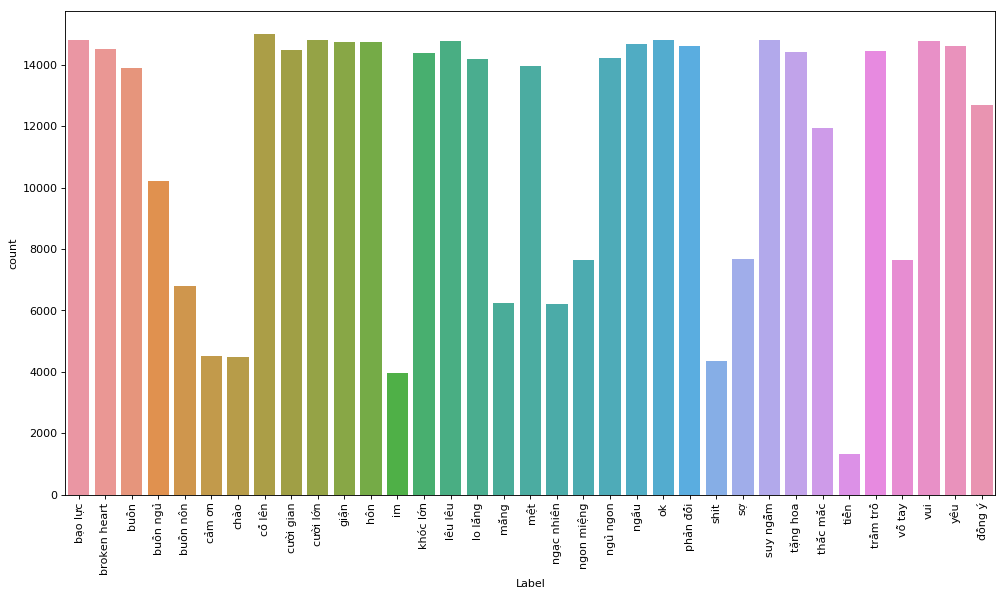

In [8]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.target)
plt.xlabel('Label')

In [9]:
Y = df.target
le = LabelEncoder()
Y = le.fit_transform(Y)

In [10]:
def detect_emotion(arr):
    max_len = 30
    test = [str(s) for s in arr]
    sequences = tok.texts_to_sequences(test)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    emotion = []
    print(    sequences_matrix.shape)
    rs = model.predict( sequences_matrix , batch_size=1024, verbose=1, steps=None)
    return (rs)

In [12]:
X = df.status
Y = df.target

In [16]:
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state=42)

In [14]:
test_list = X.tolist()
label_list = le.transform(Y.tolist())

In [15]:
final = detect_emotion(test_list)

(401378, 30)
401378/401378 [==============================] - 8s 19us/step


In [16]:
final = np.argmax(final,axis=1)

TÍNH F1

In [17]:
precision_score(label_list, final, average='macro')

/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.048248921958781166

In [18]:
recall_score(label_list, final, average='macro')

0.03607037527872647

In [19]:
f1_score(label_list, final, average='macro')

/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01991025248627248

CONFUSION MATRIX

In [20]:
cm = confusion_matrix(label_list, final)

In [21]:
import seaborn

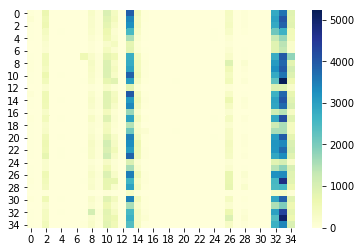

In [22]:
seaborn.heatmap(cm, cmap="YlGnBu")

In [23]:
x=[sum(cm[i]) - cm[i,i] for i in range (35)]
y=[sum(cm[i]) for i in range (35)]

In [24]:
cm_pcnt  = [cm[i]/y[i]*100 for i in range (35)]

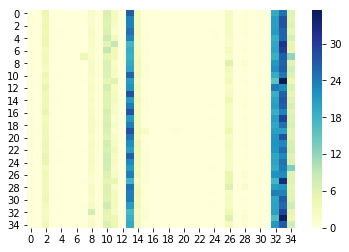

In [25]:
seaborn.heatmap(cm_pcnt, cmap="YlGnBu")

CORRELATION

In [26]:
tag_label = [(str(le.inverse_transform([i])[0])) for i in range(35)]

In [28]:
cls_report = classification_report(label_list, final, target_names=tag_label, output_dict=True)

/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
outfile = "classification_report_focal_loss.txt"
with open(outfile, "w") as f:
    f.write(cls_report)

TypeError: write() argument must be str, not dict

In [29]:
arr_f1_score = []
arr_support = []
for i in range (35):    
    arr_f1_score.append(cls_report[tag_label[i]]['f1-score'])
    arr_support.append(cls_report[tag_label[i]]['support'])                   

In [30]:
np.corrcoef(arr_f1_score, arr_support)

array([[1.        , 0.47065613],
       [0.47065613, 1.        ]])

In [31]:
scipy.stats.spearmanr(arr_f1_score, arr_support)

SpearmanrResult(correlation=0.4735875534005658, pvalue=0.004057961327538879)

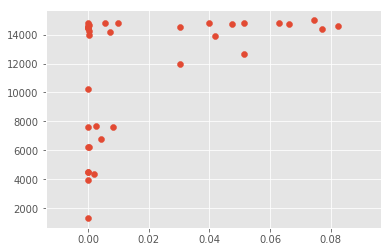

In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

plt.scatter(arr_f1_score, arr_support)
plt.show()

In [33]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [34]:
with open("stop_word.txt",'r') as f :
    sw = f.readlines()
for i in range (len(sw)):
    sw[i] = sw[i].strip('\n')

In [35]:
def word_cloud_plot(text,label):    
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.savefig("word_cloud_focal_loss_testdata/" + label +".png")

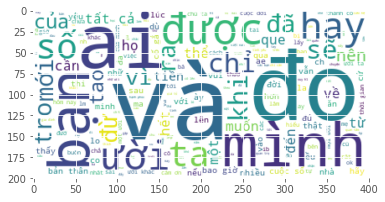

In [37]:
for i in range(35):
    data = df.status[df.target == tag_label[i]]
    text = " ".join(str(row) for row in data)   
    for j in range(len(sw)):
        text = text.replace(sw[j],'')
    if i == 4:
        text = text.replace('chị','')
    word_cloud_plot(text, tag_label[i])